In [1]:

import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore') #, category=RuntimeWarning) # , category=FutureWarning)


from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask
import dask.array as da

import itertools

from collections import OrderedDict

import inout as io
import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

### Launch dask cluster

In [23]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 4
# number of nodes
jobs = 2
nworkers = workers_per_job * jobs

# type of cluster
config = 1

if config==1:
    # pour 1 seul noeud
    cluster = LocalCluster(n_workers=2, threads_per_worker=2)
    client = Client(cluster)
else:
    # pour plusieurs noeuds:
    # ** processes and cores may be adjusted in order to have more memory 
    # or inversely more computational ressource
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
    w = cluster.scale(jobs=jobs)
    #cluster.adapt(minimum=1, maximum=5)

    client = Client(cluster)
    wait_cluster_ready(cluster, nworkers)
    
# put tmp files of dask in the scratch directory
try:
    scratch = os.environ['SCRATCH']
except:
    scratch = os.environ['HOME']
dask.config.set(local_directory=scratch)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 110.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56400,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 110.00 GiB
Comm: tcp://127.0.0.1:42354,Total threads: 2
Dashboard: http://127.0.0.1:39325/status,Memory: 55.00 GiB
Nanny: tcp://127.0.0.1:47115,


---
### Parameters

In [3]:
# Benguela Initialization xios template
# path = "/home/datawork-croco/public/ftp/CONFIGS_EXAMPLES/OUTPUT_FILES_BENGUELA_LR/XIOS_FORMAT/"
# filenames = [path+"croco_1d_inst_2005-03-01-2005-03-31.nc"]
# gridname = path+"croco_1d_inst_2005-03-01-2005-03-31.nc"
# longitude = 14.
# latitude = -32.
# depth = -100.
# seldate = "2005-04-01"
# model = "croco_xios"

# Benguela Initialization croco_native template
path = "/home/datawork-croco/public/ftp/CONFIGS_EXAMPLES/OUTPUT_FILES_BENGUELA_LR/NATIVE_FORMAT/"
filenames = [path+"croco_his_20050301_20050331.nc"]
gridname = path+"croco_his_20050301_20050331.nc"
longitude = 14.
latitude = -32.
depth = -100.
seldate = 1.655424e+08
model = "croco_native"

--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [4]:
croco = Model(model)

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [5]:
%%time
drop_variables = [] 
ds, xgrid = io.open_files(croco, gridname, filenames, grid_metrics=2, 
                          drop_variables=drop_variables,
                          chunks={'t':1},
                          # chunks={'t':1, 's':1, 's_w':1},
                         )
ds

CPU times: user 444 ms, sys: 28 ms, total: 472 ms
Wall time: 973 ms


<xarray.Dataset>
Dimensions:           (t: 31, x: 41, x_u: 42, y: 42, y_v: 43, s: 32, s_w: 33,
                       auxil: 4)
Coordinates: (12/20)
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39 40
  * x_u               (x_u) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * y                 (y) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40 41
  * y_v               (y_v) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42
  * s                 (s) float32 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * s_w               (s_w) float32 -1.0 -0.9688 -0.9375 ... -0.03125 0.0
    ...                ...
    lat_p             (y_v, x_u) float32 dask.array<chunksize=(43, 42), meta=np.ndarray>
    z                 (t, s, y, x) float32 dask.array<chunksize=(1, 32, 42, 41), meta=np.ndarray>
    z_w               (t, s_w, y, x) float32 dask.array<chunksize=(1, 33, 42, 41), meta=np.ndarray>
    z_u               (t, s, y, x_u) float32 dask.array<chunksize=(1, 32, 42, 42), meta=np.ndarray>
    z_v               (t, s, y_v, x) float32 dask.array<chunksize=(1, 32, 43, 41), meta=np.ndarray>
    z_p               (t, s, y_v, x_u) float32 dask.array<chunksize=(1, 32, 43, 42), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/46)
    spherical         (t) |S1 dask.array<chunksize=(1,), meta=np.ndarray>
    xl                (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    el                (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Vtransform        (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_r              (t, s) float32 dask.array<chunksize=(1, 32), meta=np.ndarray>
    sc_w              (t, s_w) float32 dask.array<chunksize=(1, 33), meta=np.ndarray>
    ...                ...
    dy                (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    dx_u              (y, x_u) float32 dask.array<chunksize=(42, 42), meta=np.ndarray>
    dy_v              (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
    is3D              bool True
    dz                (t, s, y, x) float32 dask.array<chunksize=(1, 32, 42, 41), meta=np.ndarray>
    dz_w              (t, s_w, y, x) float32 dask.array<chunksize=(1, 33, 42, 41), meta=np.ndarray>
Attributes: (12/57)
    type:                      CROCO history file
    title:                     BENGUELA_exp2_Ofrc
    date:                      
    rst_file:                  ./croco_rst.nc
    his_file:                  ./croco_his.nc
    avg_file:                  ./croco_avg.nc
    ...                        ...
    SRCS:                      main.F step.F read_inp.F timers_roms.F init_sc...
    CPP-options:               REGIONAL BENGUELA_LR MPI OBC_EAST OBC_WEST OBC...
    history:                   Sun Jan 14 20:39:53 2024: ncrcat -O -F -d time...
    NCO:                       4.7.1
    nco_openmp_thread_number:  1
    vtransform:                NEW

In [6]:
%%time
ds1 = ds.sel(t=seldate, method='nearest')
grid = gop.fast_xgcm_grid(ds1)
ds1

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16.7 ms


<xarray.Dataset>
Dimensions:           (x: 41, x_u: 42, y: 42, y_v: 43, s: 32, s_w: 33, auxil: 4)
Coordinates: (12/20)
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39 40
  * x_u               (x_u) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * y                 (y) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40 41
  * y_v               (y_v) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42
  * s                 (s) float32 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * s_w               (s_w) float32 -1.0 -0.9688 -0.9375 ... -0.03125 0.0
    ...                ...
    lat_p             (y_v, x_u) float32 dask.array<chunksize=(43, 42), meta=np.ndarray>
    z                 (s, y, x) float32 dask.array<chunksize=(32, 42, 41), meta=np.ndarray>
    z_w               (s_w, y, x) float32 dask.array<chunksize=(33, 42, 41), meta=np.ndarray>
    z_u               (s, y, x_u) float32 dask.array<chunksize=(32, 42, 42), meta=np.ndarray>
    z_v               (s, y_v, x) float32 dask.array<chunksize=(32, 43, 41), meta=np.ndarray>
    z_p               (s, y_v, x_u) float32 dask.array<chunksize=(32, 43, 42), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/46)
    spherical         |S1 dask.array<chunksize=(), meta=np.ndarray>
    xl                float32 dask.array<chunksize=(), meta=np.ndarray>
    el                float32 dask.array<chunksize=(), meta=np.ndarray>
    Vtransform        float32 dask.array<chunksize=(), meta=np.ndarray>
    sc_r              (s) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    sc_w              (s_w) float32 dask.array<chunksize=(33,), meta=np.ndarray>
    ...                ...
    dy                (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    dx_u              (y, x_u) float32 dask.array<chunksize=(42, 42), meta=np.ndarray>
    dy_v              (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
    is3D              bool True
    dz                (s, y, x) float32 dask.array<chunksize=(32, 42, 41), meta=np.ndarray>
    dz_w              (s_w, y, x) float32 dask.array<chunksize=(33, 42, 41), meta=np.ndarray>
Attributes: (12/57)
    type:                      CROCO history file
    title:                     BENGUELA_exp2_Ofrc
    date:                      
    rst_file:                  ./croco_rst.nc
    his_file:                  ./croco_his.nc
    avg_file:                  ./croco_avg.nc
    ...                        ...
    SRCS:                      main.F step.F read_inp.F timers_roms.F init_sc...
    CPP-options:               REGIONAL BENGUELA_LR MPI OBC_EAST OBC_WEST OBC...
    history:                   Sun Jan 14 20:39:53 2024: ncrcat -O -F -d time...
    NCO:                       4.7.1
    nco_openmp_thread_number:  1
    vtransform:                NEW

### Density at the surface

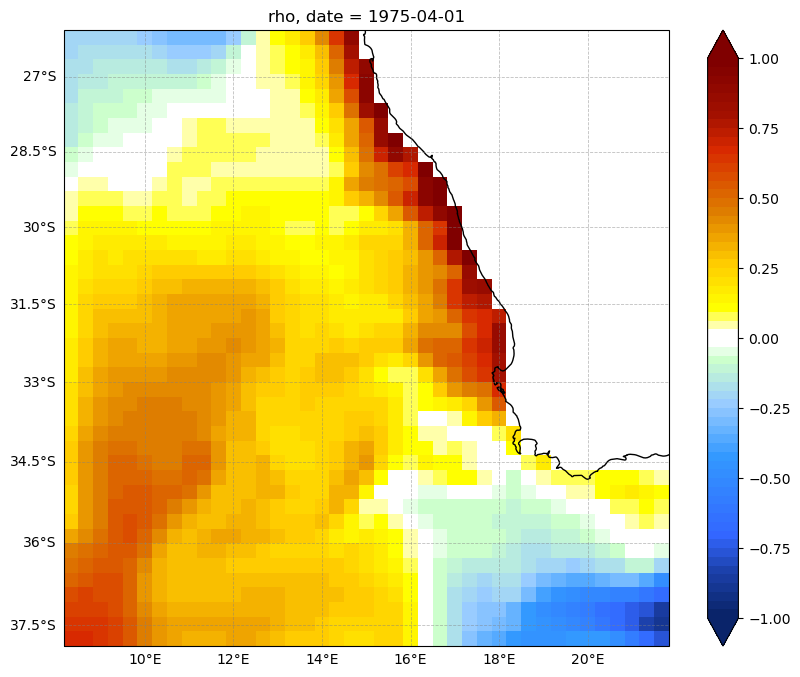

In [7]:
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
rho =dg.density(ds1.temp, ds1.salt, z)*ds1.mask
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(rho.isel(s=-1), fig_prefix = 'rho', **kwargs)

### U slice at a constant depth

CPU times: user 728 ms, sys: 148 ms, total: 876 ms
Wall time: 14.1 s


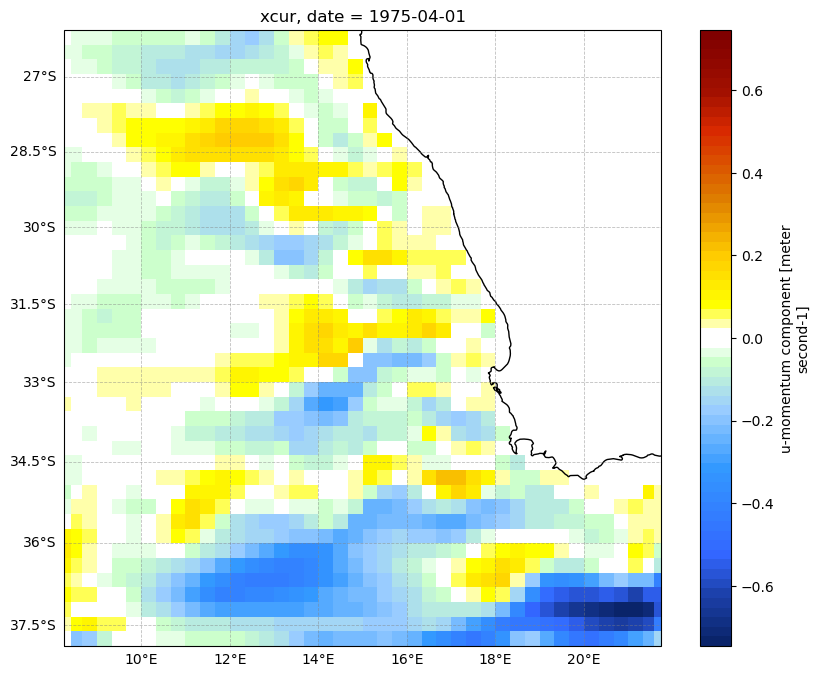

In [8]:
%%time
# depths at u points
z_u = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='u')
# slice of u at a constant depth
# uslice= gop.slices(croco, ds1.xcur, z_u, ds=ds1, depth=depth)
uslice = gop.isoslice(ds1.xcur, depth, grid, target_data=z_u, axis="z")
# # plot the slice of u
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(uslice) #, **kwargs)

### V slice at a constant depth

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 281 ms


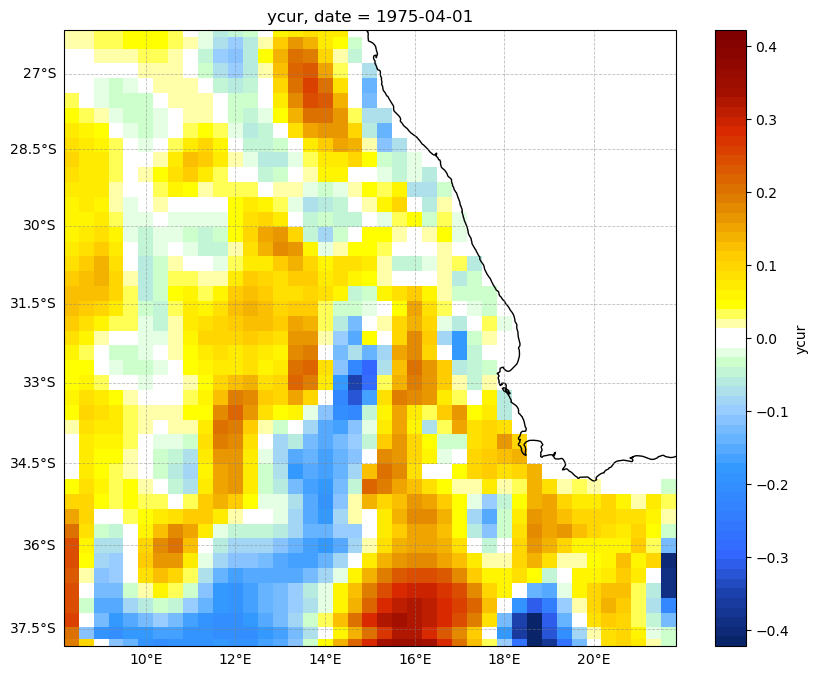

In [9]:
%%time
# depth at v points
z_v = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, hgrid='v')
# slice of v at a constant depth
vslice= gop.slices(croco, ds1.ycur, z_v, ds=ds1, depth=depth)
# plot the v slice
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(vslice) #, **kwargs)

### Rotate u,v to lat,lon coord

In [10]:
%%time
# depth at rho points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
aslice= ds1.angle
# compute u_EW and v_SN
[urot,vrot] = gop.rot_uv(uslice, vslice, aslice, grid)

CPU times: user 432 ms, sys: 4 ms, total: 436 ms
Wall time: 433 ms


### Compute relative vorticity

CPU times: user 196 ms, sys: 36 ms, total: 232 ms
Wall time: 220 ms


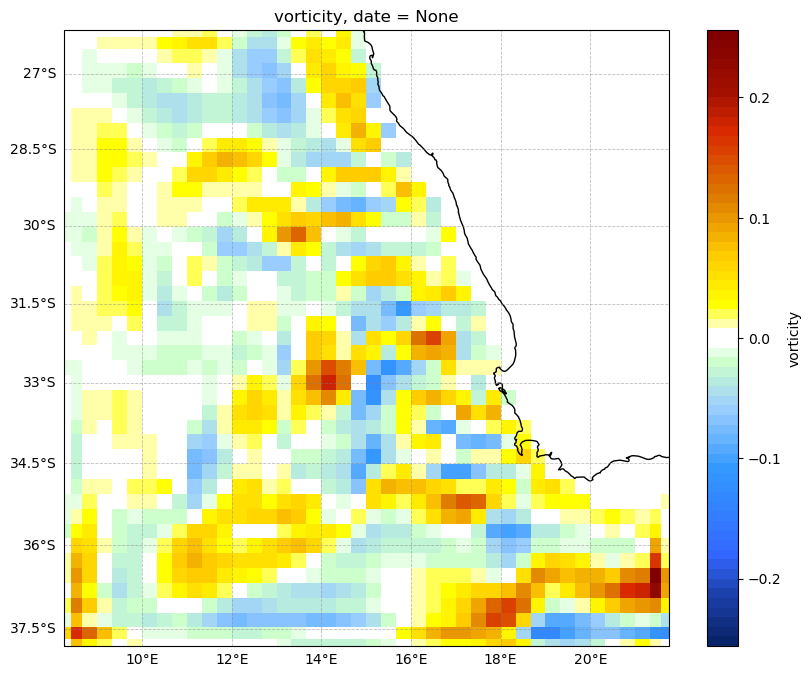

In [17]:
%%time
# compute the relative vorticity at a constant depth
relvort = dg.relative_vorticity_z(croco, ds=ds1, xgrid=grid, u=urot, v=vrot)
# plot the relative vorticity
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(relvort) #, **kwargs)

### Compute dtemp/dz on a longitudinal slice

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 104 ms


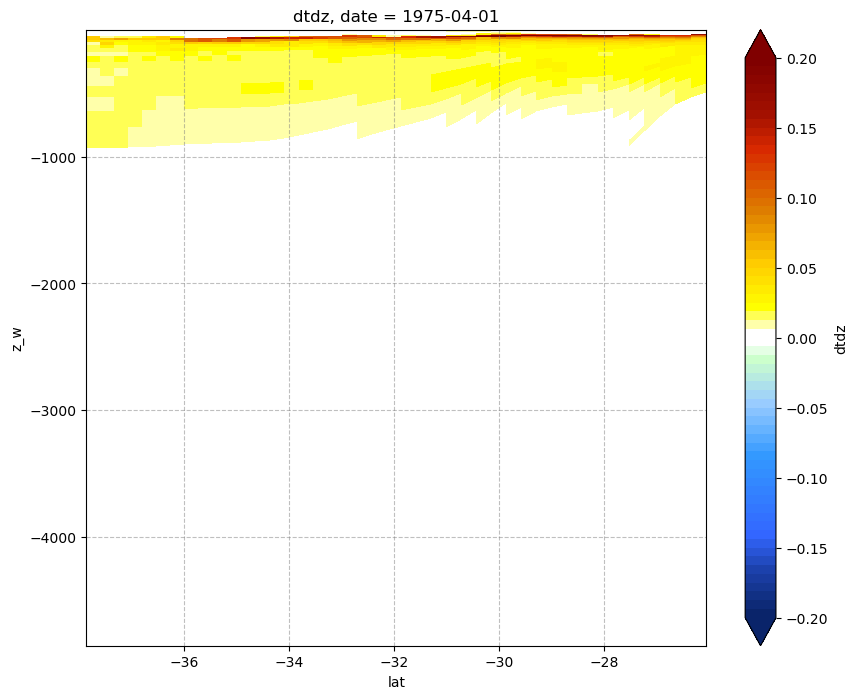

In [18]:
%%time
# longitudinal slice of temperature
tslice = gop.slices(croco, ds1.temp, z, ds=ds1, longitude=longitude)
# compute dtemp/dz
dtdz = dg.dtempdz(xgrid, tslice, tslice.z)
# plot dtemp/dz
kwargs = {'vmin': -0.2, 'vmax': 0.2, 'extend':'both'}
cplt.plotfig(dtdz, **kwargs)

### Compute Richardson on a longitudinal slice

CPU times: user 388 ms, sys: 4 ms, total: 392 ms
Wall time: 428 ms


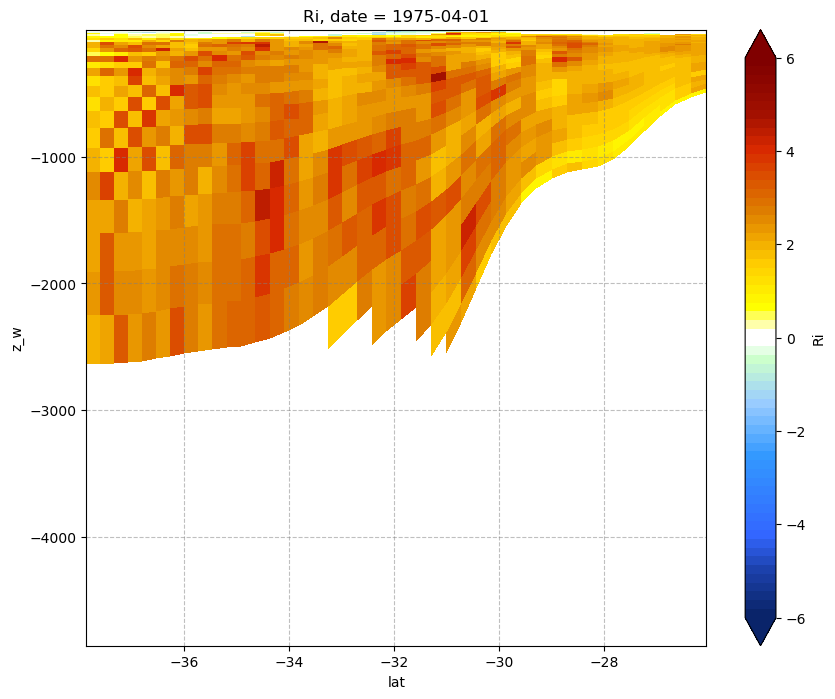

In [19]:
%%time
# longitudinal slices of rho,u,v
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
rho = dg.density(ds1.temp, ds1.salt, z=z)
rslice = gop.slices(croco, rho, z, ds=ds1, longitude=longitude)
uslice = gop.slices(croco, ds1.xcur, z_u, ds=ds1, longitude=longitude)
vslice = gop.slices(croco, ds1.ycur, z_v, ds=ds1, longitude=longitude)
# compute the Richardson number
Ri = dg.richardson(grid, uslice, vslice, rslice, rslice.z)
# plot the Richardson number
kwargs = {'vmin': -6., 'vmax': 6., 'extend':'both'}
cplt.plotfig(Ri, **kwargs)

### Compute the Pressure

CPU times: user 480 ms, sys: 60 ms, total: 540 ms
Wall time: 512 ms


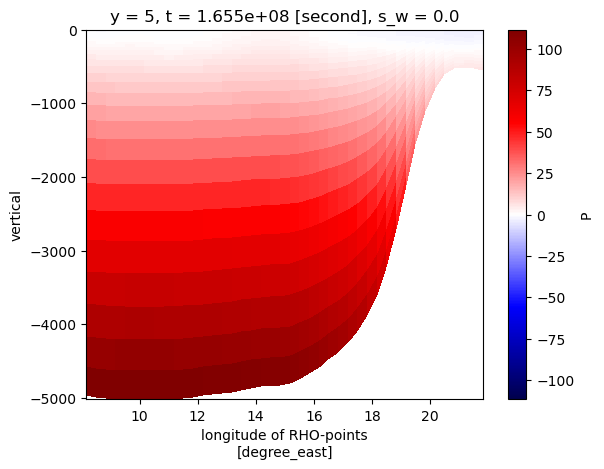

In [20]:
%%time
# depth at rho points and w points
z_r = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
z_w = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='w')
rho = dg.density(ds1.temp, ds1.salt, z=z)
# compute the pressure
P = dg.get_p(grid, rho, z_w, z_r)
# plot the pressure
coords = gop.get_spatial_coords(P)
P.isel(y=int(P.y.size/8)).plot(x=coords['lon'], y=coords['z'], cmap="seismic")

CPU times: user 736 ms, sys: 0 ns, total: 736 ms
Wall time: 722 ms


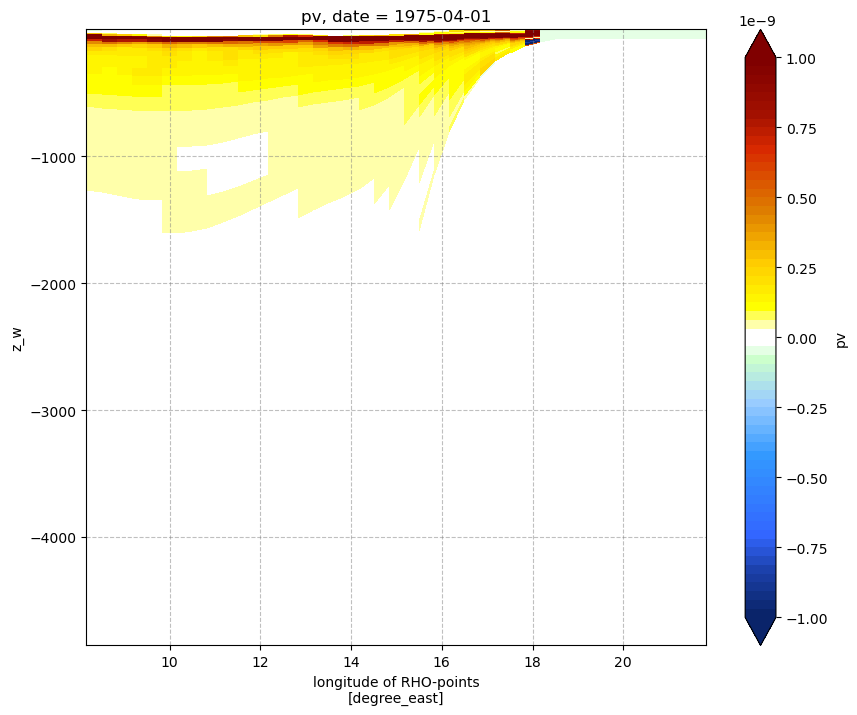

In [21]:
%%time
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
rho = dg.density(ds1.temp, ds1.salt, z=z)
pv = dg.ertel_pv(grid, ds1.xcur, ds1.ycur, ds1.zcur, rho, z, ds1.f)
kwargs = {'vmin': -1.e-9, 'vmax': 1.e-9, 'extend':'both'}
cplt.plotfig(pv.isel(y=int(ds1.y.size*0.5)), **kwargs)


In [22]:
cluster.close()